# Natural Language Processing (NLP) with Tensorflow

## What we're goint to cover?

- Downloading and preparing a text dataset
- How to prepare text dataset for modelling (`tokenization embedding`)
- Setting up multiple modelling experiments with recurrent neural networking (RNNs)
- Build a text `feature extraction model using Tensorflow Hub`
- Finding the most wrong predictions examples
- Using a model we've built to make predictions on text from the wild

see: https://en.wikipedia.org/wiki/Recurrent_neural_network  
see: https://awari.com.br/deep-learning-rnn-utilizando-redes-rnn-recurrent-neural-networks-no-deep-learning/

RNN - Recurrent Neural Network  
LSTM - Long short-term memory

how to add deep learning model in android application: https://www.youtube.com/watch?v=tySgZ1rEbW4&t=987s


| Hyperparameter/Layer Type | What does it do?                                               | Typical Value                                                                        |
| ------------------------- | -------------------------------------------------------------- | ------------------------------------------------------------------------------------ |
| Input (txt)               | Target text/sequencial you'd like to discover pattern in       | whatever you can represent as text or a sequence                                     |
| Input Layer               | Takes target in sequence                                       | input_shape = [batch_size, embedding_size] or [batch_size, sequence_shape]           |
| Text Vectorization Layer  | Maps input sequences to number                                 | tf.keras.layer.experimental.preprocessing.TextVectorization                          |
| Embedding                 | mapping of text vectors to embedding matrix (how words relate) | tf.keras.layers.Embedding                                                            |
| RNN                       | Finds patterns in sequence                                     | SimpleRNN, LSTM, GRU                                                                 |
| Hidden activation         | Adds non-linearity to learned features (non-streigh-line)      | Usually Tanh (hyperbolic tangent) tf.keras.activations.tanh                          |
| Pooling Layer             | Reduces the dimensionality of learned sequence (ConvD1)        | tf.keras.layers.GlobalAlveragePooling1D or tf.keras.layers.GlobalMaxPool1D           |
| Full connected Layer      | Futher refines learned features from recurrent layers          | tf.keras.layers.Dense                                                                |
| Output Layer              | Takes learned features outputs them in shape of target labels  | output_shape = number_of_classes                                                     |
| Output Activation         | Adds non-linearities to output layer                           | tf.keras.activations.sigmoid (binary classification) or tf.keras.activations.softmax |


```python
from tensorflow.keras import layers

# create LSTM Model
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs) # turn input sequence to number
x = embedding(x) # create embedding matrix
x = layers.LSTM(64, activation='tanh')(x) # return vector for whole sequence
outputs = layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

# compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# fit the model
history = model.fit(train_sequences, train_labels, epochs=5)
```


## Check GPU


In [ ]:
!nvidia-smi -L

In [2]:
import os
import sys

# add path root project to read helper fuctions
sys.path.append(os.path.join('../'))

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf
tfhub_url = 'https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2'

# create a Keras Layer using the pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer(tfhub_url, 
                                        input_shape=[], 
                                        dtype=tf.string,
                                        trainable=False, 
                                        name='USE')

## Helper Functions

In past modules, we've created a brunch of helper functions to do small task required for our notebooks. Rather than rewrite all these, we can import a script and load them in from threre. The script we've got available can be found on github: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


In [ ]:
# import urllib.request as ur
# uncomment this line below and run it to download helper_functions file
# ur.urlretrieve('https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py', filename='helper_functions.py')
from helper_functions import create_tensorboard_callback

## Kaggle Dataset

The dataset we're going to be using is Kaggle's introduction to NLP dataset

see: https://www.kaggle.com/competitions/nlp-getting-started  
see: https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip


In [3]:
STORAGE = os.path.join('../../', 'storage')
IMAGE_PATH = f'{STORAGE}/images'
ZIP_PATH = f'{STORAGE}/zip'
MODEL_PATH = f'{STORAGE}/models'
NLP = f'{STORAGE}/nlp'

# concat paths
LIST_PATHS = [IMAGE_PATH, ZIP_PATH, MODEL_PATH, NLP]

# create a directory to save tensorboard logs
tensorboard_logs = f'{NLP}/tensorboard/logs'

In [ ]:
# confirm dir create
os.listdir(STORAGE)

In [ ]:
for dir in LIST_PATHS:
    if not os.path.exists(dir):
        os.mkdir(dir)

In [ ]:
filename = 'nlp_getting_started.zip'
url = f'https://storage.googleapis.com/ztm_tf_course/{filename}'
folder = filename.split('.')[0]

# unzip_data(url, filename, ZIP_PATH, NLP)

## Visualizing a text dataset

see: https://www.w3schools.com/python/python_file_open.asp  
see: https://www.tensorflow.org/tutorials/load_data/text?hl=pt-br

To visualize our text samples, we first have to read them in, one way to do would be to use python read, but we prefer to get visual straight away. So another way to do this is to sue pandas library.


In [7]:
import pandas as pd

train_df = pd.read_csv(f'{NLP}/train.csv')
test_df = pd.read_csv(f'{NLP}/test.csv')

In [ ]:
display(train_df.head())

In [8]:
# shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)

In [ ]:
# how many examples of each class?
train_df.target.value_counts()

### classification when data is imbalanced

see: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=pt-br


In [ ]:
# how many total samples
train_df.shape[0], test_df.shape[0]

In [ ]:
# let's visualize some random training examples
import random

random_index = random.randint(0, train_df.shape[0] - 5) # create random indexes not higher than total of samples
for row in train_df_shuffled[['text', 'target']][random_index:random_index+5].itertuples():
    _, text, target = row
    print(f'Target: {target}', '(real disaster)' if target > 0 else '(not real disaster)')
    print(f'Text: {text}')
    print('----\n')

## Split data into training and validation sets

see: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html


In [9]:
from sklearn.model_selection import train_test_split
train_df_shuffled = train_df.sample(frac=1, random_state=42)

# use train_test_split to split training data and validation sets
train_sequences, val_sequences, train_labels, val_labels = train_test_split(train_df_shuffled['text'].to_numpy(),
                                                                           train_df_shuffled['target'].to_numpy(),
                                                                           test_size=0.1, # use 10% of training data validation
                                                                           random_state=42)

In [ ]:
# check the lengh
train_sequences.shape[0], train_labels.shape[0], val_sequences.shape[0], val_labels.shape[0]

In [ ]:
# check the first 5 samples
train_sequences[:5], train_labels[:5]

## Converting text into numbers

see: https://www.tensorflow.org/text/guide/word_embeddings?hl=pt-br

When dealing with a text problem, one of the first things you'll have to do before you can build a model is to convert your text to numbers.

There are a few ways to do this, namely:

- `Tokenization`: - direct mapping of token (a token could be a word or a character) to number

- `Embedding`: create a matrix of feature vector for each token (the size of the feature vector can be defined and this embedding can be learned)

```python

# I Love Tensorflow

                [[1, 0, 0],
OneHotEncoder = [0, 1, 0],
                [0, 0, 1]]

            [[0.234, 0.2323, 0.34],
Embedding = [0.343, 0.222, 0.333],
            [0.111, 0.343, 0.999]]
```

`Tokenization`: straight mapping from token to number (can be modelled but quick get too big)  
`Embedding`: richer representation of relationship between tokens (can limit size + can be learned)

```mermaid
graph TD;
    A[I Love Tensorflow] -->  Number[0 1 2]
    A[I Love Tensorflow] --> OneHotEncoder[1, 0, 0
                                0, 1, 0
                                0, 0, 1 ]
    A[I Love Tensorflow] --> Embedding[0.234, 0.2323, 0.34
                                0.343, 0.222, 0.333,
                                0.111, 0.343, 0.999]
```


In [ ]:
import tensorflow as tf

# use the default TextVectorization parameters
text_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=None, # how many words in the vocabulary (automatically add <OOV>)
                                                                               standardize='lower_and_strip_punctuation',
                                                                               split='whitespace',
                                                                               ngrams=None, # create groups of n-words?
                                                                               output_mode='int', # how to map tokens to number
                                                                               output_sequence_length=None, # how long do you want your sequence to be
                                                                               pad_to_max_tokens=False)

## Text Vectorization (Tokenization)

see: https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization  
see: https://keras.io/api/layers/preprocessing_layers/text/text_vectorization/  
see: https://en.wikipedia.org/wiki/Tf%E2%80%93idf  
see: https://monkeylearn.com/blog/what-is-tf-idf/


In [ ]:
len(train_sequences[2].split())

In [ ]:
round(sum([len(i.split()) for i in train_sequences]))

In [ ]:
# Find the average number of tokens (words) in the training tweets
# WARNING:
# this value is very important to final of processing
round(sum([len(i.split()) for i in train_sequences])/len(train_sequences))

In [32]:
# setup text vectorization variables
max_vocab_length = 10000 # max number of words to have in our vacabulary
max_length = 15 # max length our sequences will be (e.g how many words from a Tweet does a model see?)

In [33]:
text_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=max_vocab_length,
                                                                               standardize='lower_and_strip_punctuation',
                                                                               split='whitespace',
                                                                               ngrams=None,
                                                                               output_mode='int',
                                                                               output_sequence_length=max_length,
                                                                               pad_to_max_tokens=True)

In [34]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sequences)

In [ ]:
# create a sample sequence and tokenize it
sample_sequence = "There's a flood in my street!"
text_vectorizer([sample_sequence])

In [ ]:
# choose random sentence from the training dataset and tokenize it 
random_sentence = random.choice(train_sequences)
print(f'Original Text:\n{random_sentence}\n\nVectorized: {text_vectorizer(random_sentence)}')

In [ ]:
# get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # get all the unique words in 
top_5_words = words_in_vocab[:5] # get the most common  words
bottom_5_words = words_in_vocab[-5:]  # get the least common words

print(f'Number of words in vocabulary: {len(words_in_vocab)}')
print(f'5 most common words: {top_5_words}')
print(f'5 least common words: {bottom_5_words}')

## Creating an Embedding using an Embedding Layer

To make our embedding we going to use tensorflow's embedding layer: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

The parameters we care most about for our embedding layer:

- `input_dim`: the size of our vocabulary
- `output_dim`: the size of the output embedding vector for example, a value fo 100 would mean each token gets represented by a vector 100 long
- `input_length`: length of the sequences being passed to the embedding layer


In [35]:
embedding = tf.keras.layers.Embedding(input_dim=max_vocab_length, # set input shape
                                      output_dim=128,
                                      embeddings_initializer='uniform',
                                      input_length=max_length, # how long is each input
                                      )
embedding

In [ ]:
# choose random sentence from the training dataset and tokenize it 
random_sentence = random.choice(train_sequences)
print(f'Original Text:\n{random_sentence}\n\nEmbedding:\n{embedding(text_vectorizer([random_sentence]))}')

In [ ]:
sample_embedding = embedding(text_vectorizer([random_sentence]))
sample_embedding

In [ ]:
sample_embedding[0][0], random_sentence

## Modelling a text dataset (running a series of experiments)

see: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

0. Model: Naive Bayes with `TF-IDF` encoder (baseline)
1. Model: Feed Forward Neural Network (dense model)
2. Model: `LTSM` (RNN) Long-Short Term Memory Recurrent Neural Network
3. Model: `GRU` (RNN) Gated Recurrent Unit
4. Model: Bidirection `LTSM` (RNN)
5. Model: 1D Convolutional Neural Network
6. Model: Tensorflow Hub Pretrained Feature Extractor
7. Model: Tensorflow Hub Pretrained Feature Extractor (10% of data)

Now we've a got way to turn our text sequences into numbers, it's time to start building a series of modelling experiments. We'll start with a baseline and move on from here.

How are we going to approach all of these?

- Create a model
- Build a model
- Fit a model
- Evaluate a model


## Model 0: Getting a baseline

As with all machine learning modelling experiments, it's important to create a baseline model so you've got a benchmark for future experiments to build upon.

To create our baseline, we'll use Sklearn's Multinomial Naive Bayes using the TF-IDF formula to convert our words to numbers.

> **Note**: It's common practice to use non-DL (non-deep-learning) algorithms as a baseline because of their speed and then later using DL to see if you can improve upon them.


In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [37]:
# create tokenization and modelling pipeline
model_0 = Pipeline([ 
    ('tfidf', TfidfVectorizer()),  # convert words to number using tf-idf
    ('clf', MultinomialNB()) # model text
])

# Fit the pipeline to training data
model_0.fit(train_sequences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [39]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sequences, val_labels)
print(f'Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%')

Our baseline model achieves an accuracy of: 79.27%


In [40]:
# make predictions
baseline_preds = model_0.predict(val_sequences)
baseline_preds[:10]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0], dtype=int64)

In [44]:
# create function to evaluate: accuracy, precision, recall, f1-score
# see: https://stackoverflow.com/questions/3490738/how-to-sum-dict-elements
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from functools import reduce

def calculate_results(y_true, y_pred):
    """
    Calculate Model accuracy, precision, recal and f1-score of a binary classification model.
    """
    # calculate accuracy
    m_accuracy = accuracy_score(y_true, y_pred)

    # calculate model precision, recall and f1-score using 'weighted' average
    m_precision, m_recall, m_f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    
    results = {
        'accuracy':     m_accuracy,
        'precision':    m_precision,
        'recall':       m_recall,
        'f1':           m_f1_score}
    
    return reduce(lambda x, y: dict((k, v * 100) for k, v in results.items()), results)     

In [50]:
# get baseline results
baseline_results = calculate_results(y_true=val_labels, y_pred=baseline_preds)

In [46]:
model_results = pd.DataFrame({'model_0_results': baseline_results})
model_results.transpose()

,accuracy,f1,precision,recall
model_0_results,79.265092,78.621898,81.1139,79.265092


## Model 1: A simple dense model


In [ ]:
# build model with functional api
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string) # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numberzed inputs
# x = tf.keras.layers.GlobalAveragePooling1D()(x) # condense the feature vector for each token to one vector
x = tf.keras.layers.GlobalMaxPooling1D()(x)
# x = tf.keras.layers.GlobalAvgPool1D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x) # create the output layer, want binary outputs so use sigmoid activation functions
model_1 = tf.keras.Model(inputs, outputs, name='mode_1_dense')

In [ ]:
model_1.summary()

In [ ]:
# compile the model
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
model_1_history = model_1.fit(x=train_sequences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sequences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=tensorboard_logs, experiment_name='model_1_dense')])

In [ ]:
# check the results
# GlobalAveragePooling1D    ===>>>      [0.491241455078125, 0.7900262475013733]
# GlobalMaxPooling1D        ===>>>      [0.536510705947876, 0.7952755689620972]
# GlobalAvgPool1D           ===>>>      [0.48092105984687805, 0.7821522355079651]
model_1.evaluate(val_sequences, val_labels)
model_1_pred_probs = model_1.predict(val_sequences)


In [ ]:
# look at a single prediction
model_1_pred_probs[0]

In [ ]:
# look at the first 5
model_1_pred_probs[:5]

In [ ]:
# convert model prediction probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:5]

In [ ]:
# calculate our mode_1 results
model_1_results = calculate_results(y_true=val_labels, y_pred=model_1_preds)

In [ ]:
model_results = pd.DataFrame({'model_0_results': baseline_results,
                              'model_1_results': model_1_results})

model_results.transpose().sort_values(by='f1', ascending=False)

## Visualizing learned embedding


In [ ]:
# get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

In [ ]:
model_1.summary()

In [ ]:
# get the weight matrix of embedding layer
# (these are the numerical representations of each token in our training data)
embed_weights = model_1.get_layer('embedding').get_weights()
print(embed_weights[0].shape) # same size as vocab size and embedding_dim (output_dim of our embedding layer)

In [ ]:
# create embedding files (we got this from tensorflow's word embedding documentation)
# see: https://www.tensorflow.org/text/guide/word_embeddings?hl=pt-br
import io

out_v = io.open(f'{NLP}/vectors.tsv', 'w', encoding='utf-8')
out_m = io.open(f'{NLP}/metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[0][index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")

out_v.close()
out_m.close()

## Recurrent Neural Network (RNN's)

RNN's are useful for sequence data. The promise of a recurrent neural network is to use the representation of a previous input to aid the representation of a later input.

- MIT's sequence modelling lecture: https://www.youtube.com/watch?v=qjrad0V0uJE
- Chris Olah's intro to LSTM: https://colah.github.io/posts/2015-08-Understanding-LSTMs/
- Andrej Karpathy's the unreasonable effectiveness of recurrent neural network: https://karpathy.github.io/2015/05/21/rnn-effectiveness/

<div style="width: 720px; height:450px">
    <img src='https://miro.medium.com/v2/resize:fit:1400/1*3ltsv1uzGR6UBjZ6CUs04A.jpeg' style="width:100%">
<div>


## Model_2: LSTM

LSTM - Long Short Term Memory (one of the most popular LSTM Cell)


In [ ]:
# create an LSTM model
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.LSTM(units=64, return_sequences=True)(x)
x = tf.keras.layers.LSTM(units=64)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x) # binary classification model (0 or 1)
model_2 = tf.keras.Model(inputs, outputs, name='model_2_LSTM')

In [ ]:
model_2.summary()

In [ ]:
# compile the model
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
# Fit the model
model_2_history = model_2.fit(x=train_sequences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sequences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=tensorboard_logs, experiment_name='model_2_LSTM')])

In [ ]:
# evaluate the model
model_2.evaluate(val_sequences, val_labels)

# make predictions with LSTM Model 2
model_2_pred_probs = model_2.predict(val_sequences)

# convert model prediction probabilities to label format
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_results = calculate_results(y_true=val_labels, y_pred=model_2_preds)

In [ ]:
model_results = pd.DataFrame({'model_0_results': baseline_results,
                              'model_1_results': model_1_results,
                              'model_2_results': model_2_results})

model_results.transpose().sort_values(by='f1', ascending=False)

## Model 3: GRU (Gated Recurrent Unit)

In [ ]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.GRU(units=64, return_sequences=True)(x) # if you want to stack recurrent layer on top of each other, you need return sequences = True
x = tf.keras.layers.GRU(units=64)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
# x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x) # binary classification model (0 or 1)
model_3 = tf.keras.Model(inputs, outputs, name='model_3_GRU')

In [ ]:
model_3.summary()

In [ ]:
# compile the model
model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:

model_3_history = model_3.fit(x=train_sequences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sequences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=tensorboard_logs, experiment_name='model_3_GRU')])

In [ ]:
# evaluate the model
model_3.evaluate(val_sequences, val_labels)
model_3_pred_probs = model_3.predict(val_sequences)

# convert model prediction probabilities to label format
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))

model_3_results = calculate_results(y_true=val_labels, y_pred=model_3_preds)

In [ ]:
model_results = pd.DataFrame({'model_0_results': baseline_results,
                                  'model_1_results': model_1_results,
                                  'model_2_results': model_2_results,
                                  'model_3_results': model_3_results})
model_results.transpose().sort_values(by='f1', ascending=False)

## Model 4: Bidirectional LSTM

In [ ]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, return_sequences=True))(x) # if you want to stack recurrent layer on top of each other, you need return sequences = True
x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=64))(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x) # binary classification model (0 or 1)
model_4 = tf.keras.Model(inputs, outputs, name='model_4_bidirectional')

In [ ]:
model_4.summary()

In [ ]:
# compile the model
model_4.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
model_4_history = model_4.fit(x=train_sequences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sequences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=tensorboard_logs, experiment_name='model_4_bidirectional')])

In [ ]:
# evaluate the model
model_4.evaluate(val_sequences, val_labels)

# make predictions
model_4_pred_probs = model_4.predict(val_sequences)

# convert model prediction probabilities to label format
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))

# calculate
model_4_results = calculate_results(y_true=val_labels, y_pred=model_4_preds)

In [ ]:
model_results = pd.DataFrame({'model_0_results': baseline_results,
                                  'model_1_results': model_1_results,
                                  'model_2_results': model_2_results,
                                  'model_3_results': model_3_results,
                                  'model_4_results': model_4_results})
model_results.transpose().sort_values(by='f1', ascending=False)

## Convolutional Neural Networks for Text (and other type sequences)

We've used CNNs for images but images are typically 2D (height vs width)... however, out text data is 1D.  
Previously we've Conv2D for our image data but now we're going to use Conv1D.

### Model 5: Conv1D

see: https://poloclub.github.io/cnn-explainer/

In [ ]:
# Test out our embedding layer, Conv1D layer and max pooling
embedding_test = embedding(text_vectorizer(['this is a test sentences'])) # turn target
conv_1d = tf.keras.layers.Conv1D(filters=32,
                                 kernel_size=5, # this is also referred to as an ngram of 5 (meaning it looks at 5 words at a time)
                                 strides=1, # default
                                 activation='relu',
                                 padding='valid',   # tensorshape is (1, 11, 32) with the use of the same would be (1, 15, 32)
                                                    # default = "valid", the output is smaller than input shape, "same" means output is same shape as input
                                 )

conv_1d_output = conv_1d(embedding_test) # pass test embedding through conv1d layer
max_pool = tf.keras.layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # equivalent to get the most important feature or get the feature with the highest value

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

In [ ]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, activation='relu', padding='valid')(x)
x = tf.keras.layers.GlobalMaxPool1D()(x)
# x = tf.keras.layers.Dense(64, activation='relu')(x) 
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x) # binary classification model (0 or 1)
model_5 = tf.keras.Model(inputs, outputs, name='model_5_conv1D')

In [ ]:
model_5.summary()

In [ ]:
# compile the model
model_5.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
model_5_history = model_5.fit(x=train_sequences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sequences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=tensorboard_logs, experiment_name='model_5_conv1d')])

In [ ]:
# evaluate the model
model_5.evaluate(val_sequences, val_labels)

# make predictions
model_5_pred_probs = model_5.predict(val_sequences)

# convert model prediction probabilities to label format
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))

# calculate
model_5_results = calculate_results(y_true=val_labels, y_pred=model_5_preds)

In [ ]:
model_results = pd.DataFrame({'model_0_results': baseline_results,
                                  'model_1_results': model_1_results,
                                  'model_2_results': model_2_results,
                                  'model_3_results': model_3_results,
                                  'model_4_results': model_4_results,
                                  'model_5_results': model_5_results})
model_results.transpose().sort_values(by='f1', ascending=False)

## Model 6: Tensorflow Hub Pretrained Sentence Encoder

Now we've built a few of our own models, let's try and use transfer learning for NLP


see: https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder?hl=pt-br  
see: https://arxiv.org/abs/1803.11175  
see: https://huggingface.co/

In [ ]:
# create a model using sequencial api
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
], name='model_6_USE')


# compile the model
model_6.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
model_6.summary()

In [ ]:
# fit the model
model_6_history = model_6.fit(x=train_sequences,
                              y=train_labels,
                              epochs=6,
                              validation_data=(val_sequences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=tensorboard_logs, 
                                                                     experiment_name='model_6_USE')])

In [ ]:
# evaluate the model
model_6.evaluate(val_sequences, val_labels)

# make predictions
model_6_pred_probs = model_6.predict(val_sequences)

# convert model prediction probabilities to label format
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))

# calculate
model_6_results = calculate_results(y_true=val_labels, y_pred=model_6_preds)

In [ ]:
model_results = pd.DataFrame({'model_0_results': baseline_results,
                                  'model_1_results': model_1_results,
                                  'model_2_results': model_2_results,
                                  'model_3_results': model_3_results,
                                  'model_4_results': model_4_results,
                                  'model_5_results': model_5_results,
                                  'model_6_results': model_6_results})
model_results.transpose().sort_values(by='f1', ascending=False)

## Model 7: Tensorflow hub pretrained with 10% of dataset

In [ ]:
## NOTE: Making data splits like below leads to data leakage (model_7 trained on 10% data)
## DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VALIDATION/TEST SET INTO TRAINING SET

# create subset of 10% of the training data
# train_10_percent = train_df_shuffled[['text', 'target']].sample(frac=0.1, random_state=42)
# train_sentences_10_percent = train_10_percent['text'].to_list()
# train_labels_10_percent = train_10_percent['target'].to_list()

# len(train_sentences_10_percent), len(train_labels_10_percent)

In [ ]:
# Making a better dataset split
train_10_percent_split = int(0.1 * len(train_sequences))
train_sentences_10_percent = train_sequences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [ ]:
# create a model using sequencial api
model_7 = tf.keras.Sequential([
    sentence_encoder_layer,
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
], name='model_6_USE')


# compile the model
model_7.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# fit the model
model_7_history = model_7.fit(x=train_sequences,
                              y=train_labels,
                              epochs=6,
                              validation_data=(val_sequences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=tensorboard_logs, 
                                                                     experiment_name='model_7_USE')])

In [ ]:
# evaluate the model
model_7.evaluate(val_sequences, val_labels)

# make predictions
model_7_pred_probs = model_7.predict(val_sequences)

# convert model prediction probabilities to label format
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))

# calculate
model_7_results = calculate_results(y_true=val_labels, y_pred=model_7_preds)

In [ ]:
model_results = pd.DataFrame({'model_0_results': baseline_results,
                                  'model_1_results': model_1_results,
                                  'model_2_results': model_2_results,
                                  'model_3_results': model_3_results,
                                  'model_4_results': model_4_results,
                                  'model_5_results': model_5_results,
                                  'model_6_results': model_6_results,
                                  'model_7_results': model_7_results})

model_results = model_results.transpose().sort_values(by='accuracy', ascending=False)
model_results

In [ ]:
model_results.plot(kind='bar', figsize=(20, 6)).legend(bbox_to_anchor=(1.0, 1.0))

## Saving and loading a trained Model

There are two main formats to save a model in Tensorflow
1. HDF5 formats
2. The `savedModel` format (this is default when using tensorflow)

In [ ]:
model_6.save(f'{MODEL_PATH}/tfhub_nlp_model.h5')

In [5]:
import tensorflow as tf
# import tensorflow_hub as hub

# Load model with custom Hub Layer (required HDF5 format)
# model_6_loaded = tf.keras.models.load_model(f'{MODEL_PATH}/tfhub_nlp_model.h5', custom_objects={'KerasLayer': hub.KerasLayer})
model_6_loaded = tf.keras.models.load_model(f'{MODEL_PATH}/08_model_6_USE_feature_extractor')

In [10]:
model_6_loaded.evaluate(val_sequences, val_labels)

24/24 [==============================] - 14s 25ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723122239112854, 0.8162729740142822]

In [ ]:
# Save TF Hub Sentence Encoder Model to SavedModel format (default)
# model_6.save(f'{MODEL_PATH}/tfhub_nlp_model')

In [ ]:
# model_6_saved_model = tf.keras.models.load_model(f'{MODEL_PATH}/tfhub_nlp_model')

## Finding the most wrong examples

* if our best model still isn't perfect, what examples is it getting wrong?
* and of these wrong examples which ones is it getting **most wrong** (those will prediction probabilities closet to the oposite class)

for example if a sample should have a label 0 but our model predict a prediction probability of 0.999 (really close 1) and vice versa.

In [4]:
# download a pretrained model from google storage
from helper_functions import download_unzip_data

filename = '08_model_6_USE_feature_extractor.zip'
url = f'https://storage.googleapis.com/ztm_tf_course/{filename}'

# download_unzip_data(url, filename, ZIP_PATH, MODEL_PATH)

In [47]:
# make predictions with the loaded model
model_6_loaded_preds_prob = model_6_loaded.predict(val_sequences)
model_6_loaded_preds = tf.squeeze(tf.round(model_6_loaded_preds_prob))

model_6_loaded_results = calculate_results(y_true=val_labels, y_pred=model_6_loaded_preds)

24/24 [==============================] - 0s 14ms/step


In [18]:
# create dataframe with validation sentences and best performing model predictions
val_df = pd.DataFrame({'text': val_sequences,
                       'target': val_labels,
                       'prediction': model_6_loaded_preds,
                       'prediction_probability': tf.squeeze(model_6_loaded_preds_prob)})

In [20]:
val_df.head()

,text,target,prediction,prediction_probability
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [26]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df['target'] != val_df['prediction']].sort_values(by='prediction_probability', ascending=False)
most_wrong.head(5) # these are false positives

,text,target,prediction,prediction_probability
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213


In [27]:
most_wrong.tail(5) # these are false negatives

,text,target,prediction,prediction_probability
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


In [28]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


## The speed/score tradeoff

In [29]:
# let's make a function to measure the time of prediction
import time

def pred_timer(model, samples):
    """
    Times how long a model takes to make predictions on samples
    """
    # get start time
    start_time = time.perf_counter()
    
    # make predictions
    model.predict(samples)
    
    # get finish time
    end_time = time.perf_counter()

    # calculate how long prediction took to make
    total_time = end_time - start_time
    
    time_per_pred = total_time/len(samples)
    return total_time, time_per_pred

In [30]:
model_6_loaded_total_time, model_6_loaded_per_pred = pred_timer(model=model_6_loaded, 
                                                                samples=val_sequences)
model_6_loaded_total_time, model_6_loaded_per_pred

24/24 [==============================] - 0s 15ms/step


(0.5327792999996745, 0.0006991854330704391)

In [38]:
model_0_loaded_total_time, model_0_loaded_per_pred = pred_timer(model=model_0, 
                                                                samples=val_sequences)
model_0_loaded_total_time, model_0_loaded_per_pred

(0.07200689999990573, 9.449724409436447e-05)

In [49]:
model_results

,model_0_results
accuracy,79.265092
f1,78.621898
precision,81.113900
recall,79.265092


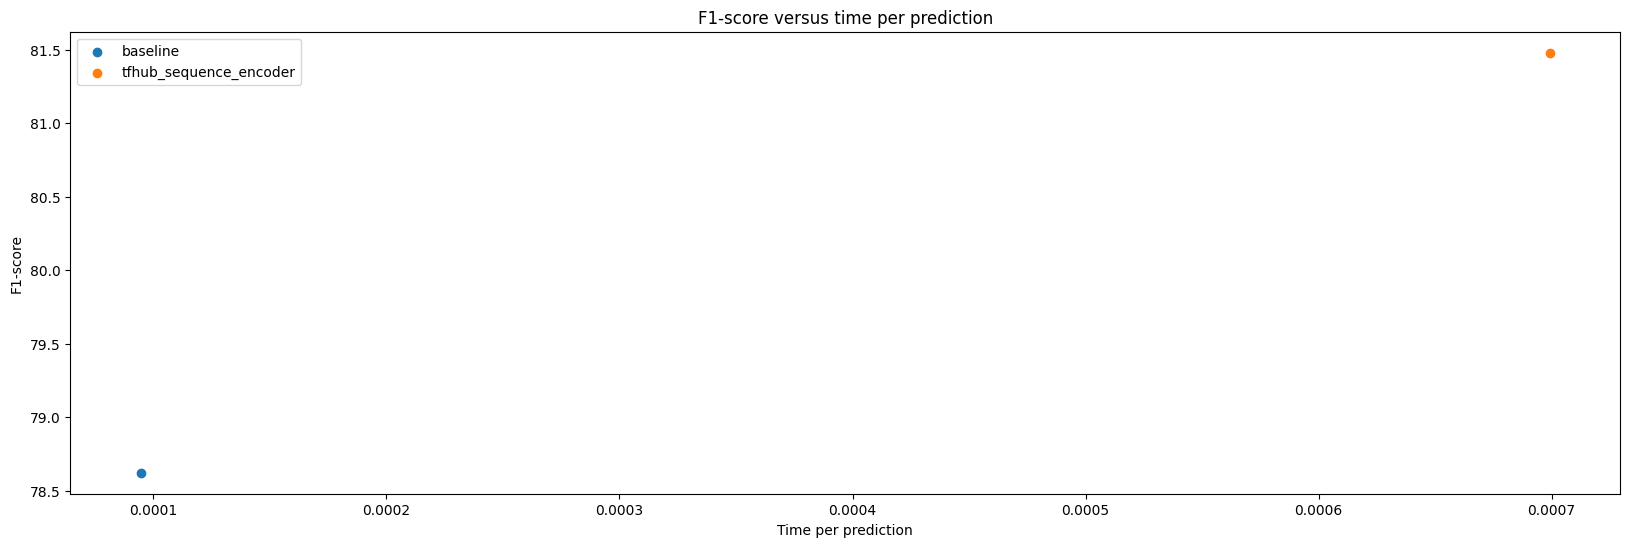

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
plt.scatter(model_0_loaded_per_pred, baseline_results['f1'], label='baseline')
plt.scatter(model_6_loaded_per_pred, model_6_loaded_results['f1'], label='tfhub_sequence_encoder')
plt.legend()
plt.title('F1-score versus time per prediction')
plt.xlabel('Time per prediction')
plt.ylabel('F1-score');